In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_error

from pylab import *

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from ReliefF import ReliefF
from sklearn.feature_selection import RFE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# Prétraitement de données

In [2]:
train = pd.read_csv("D:\\My computer\\G\\Agro_IODAA(2015_2016)\\Kaggle\\data\\train.csv")
test = pd.read_csv("D:\\My computer\\G\\Agro_IODAA(2015_2016)\\Kaggle\\data\\test.csv")

In [3]:
train.describe()

C:\Users\Riheng Zhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,NaN,7553.500000,5.000000,5.000000,1954.000000,1967.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,NaN,9478.500000,6.000000,5.000000,1973.000000,1994.000000,NaN,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,NaN,11601.500000,7.000000,6.000000,2000.000000,2004.000000,NaN,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


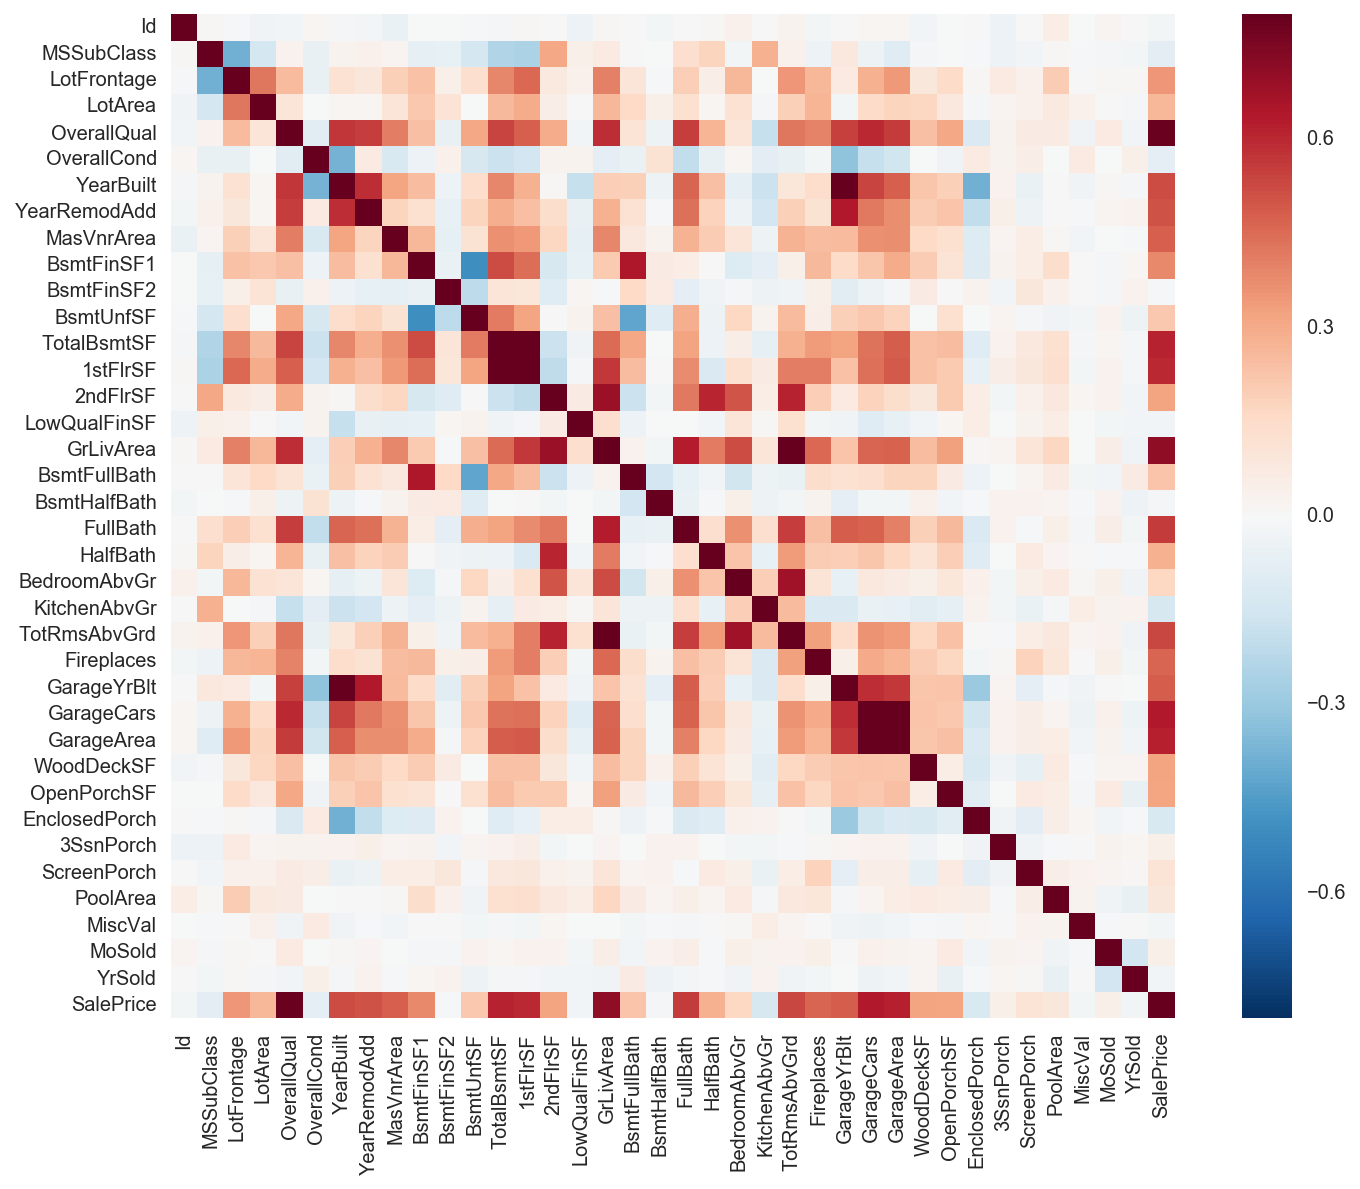

In [4]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

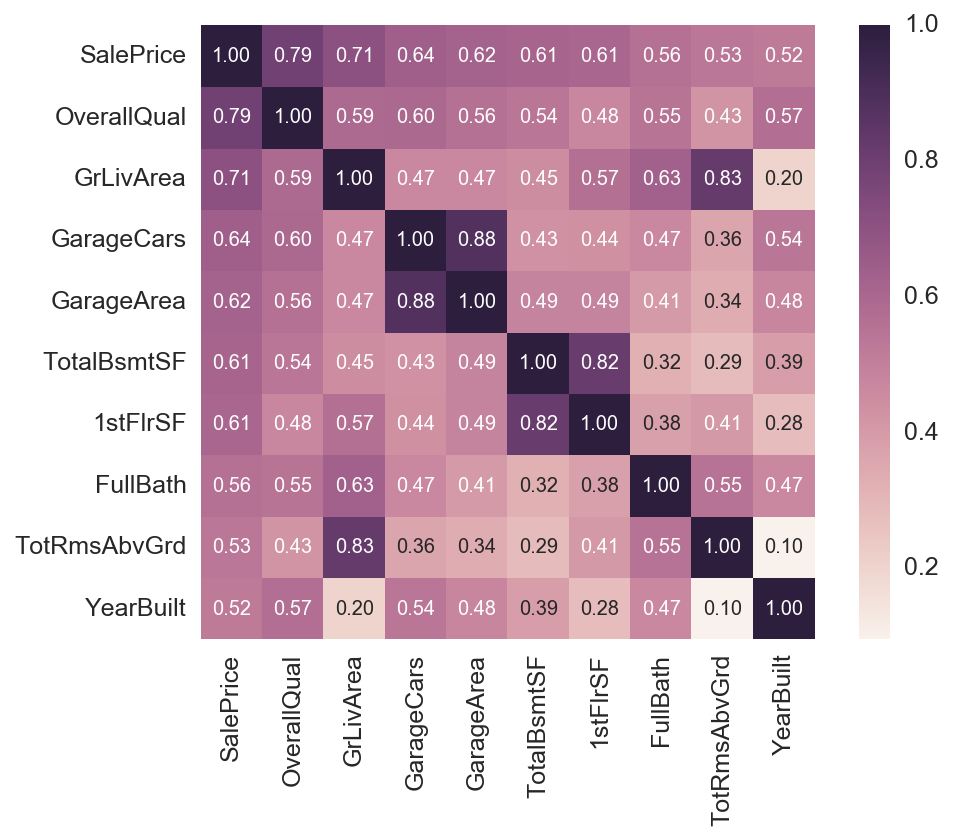

In [5]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [6]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
#transform the target on log
train['SalePrice']=np.log1p(train['SalePrice'])
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [8]:
all_data=pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
all_data.shape

(2919, 288)

In [10]:
all_data=all_data.drop(["1stFlrSF","GarageCars","GrLivArea","GarageYrBlt"],axis=1)
all_data.shape

(2919, 284)

In [11]:
X_train=all_data[:train.shape[0]]
X_test=all_data[train.shape[0]:]
y=train.SalePrice

# Models 

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict



We define a function to comput the error of the model

In [13]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

## Ridge Model

In [14]:
alphas = [0.05,0.1,0.3,1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]


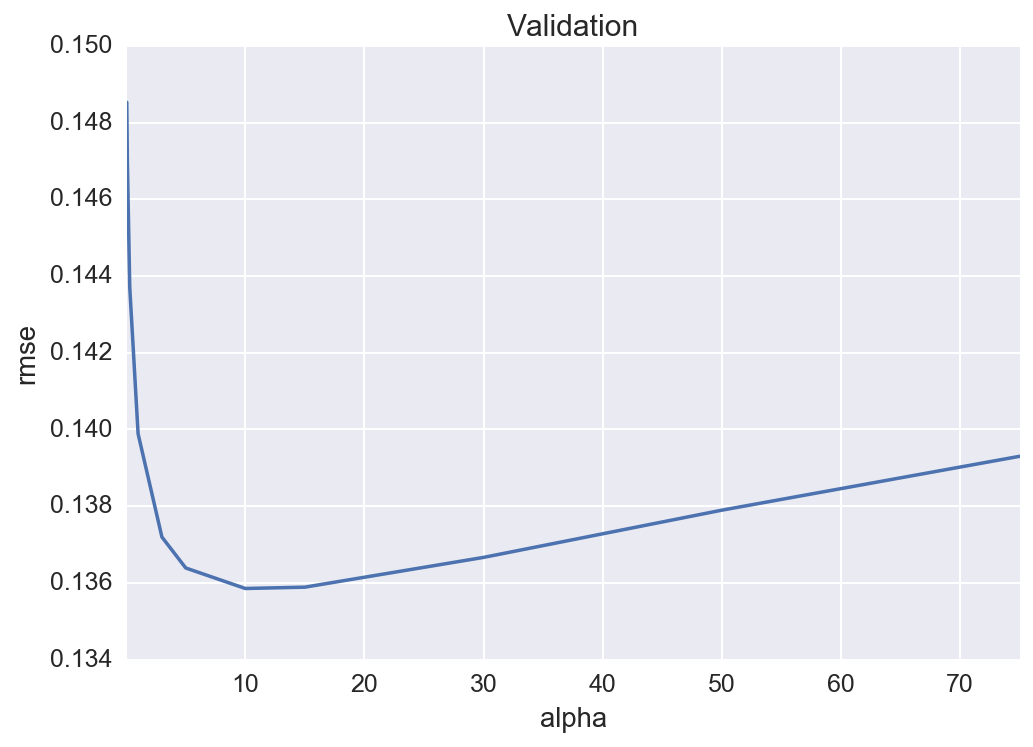

In [15]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [16]:
print(cv_ridge.min())
model_ridge=RidgeCV().fit(X_train, y)
model_ridge.alpha_

0.135853662315


10.0

## Lasso Model

In [17]:
n_alphas = 200
alphas = np.logspace(-8, 3, n_alphas)
clf =Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train, y)
    coefs.append(clf.coef_)

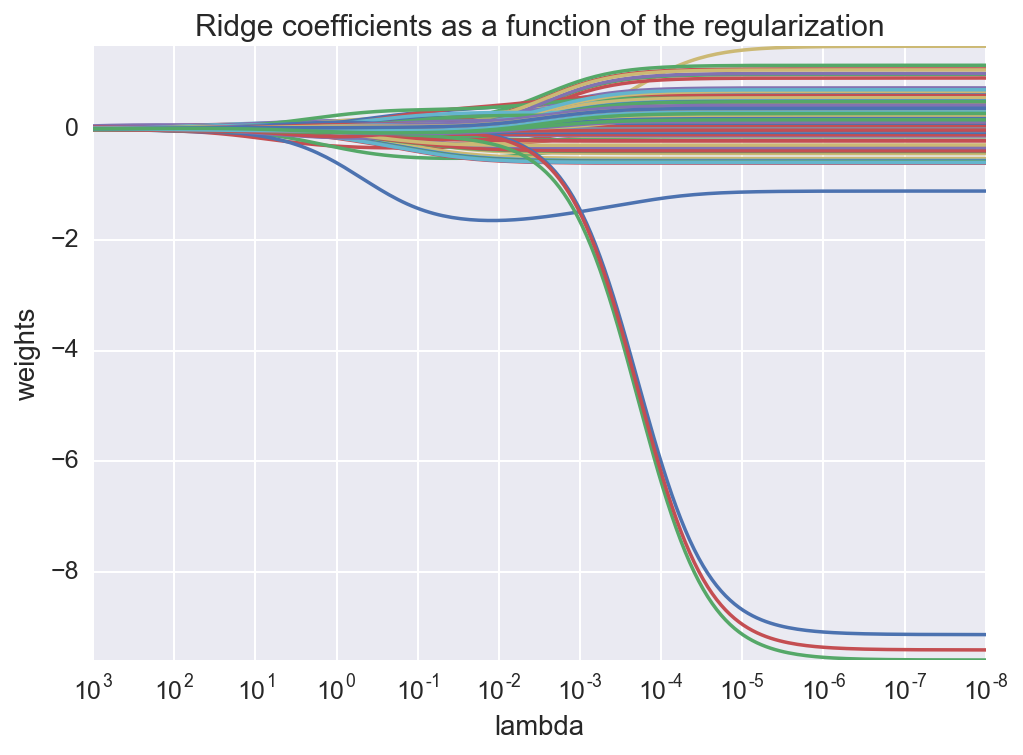

In [18]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [19]:
model_lasso=LassoCV(alphas=[ 0.1, 0.001, 0.0005]).fit(X_train,y)
model_lasso.alpha_

0.00050000000000000001

In [20]:
rmse_cv(model_lasso).min()

0.11690820272685357

In [21]:
nb_coef=sum(LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train,y).coef_!=0)
print ("Lasso choose "+str(nb_coef)+" variables")

Lasso choose 113 variables


In [22]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])


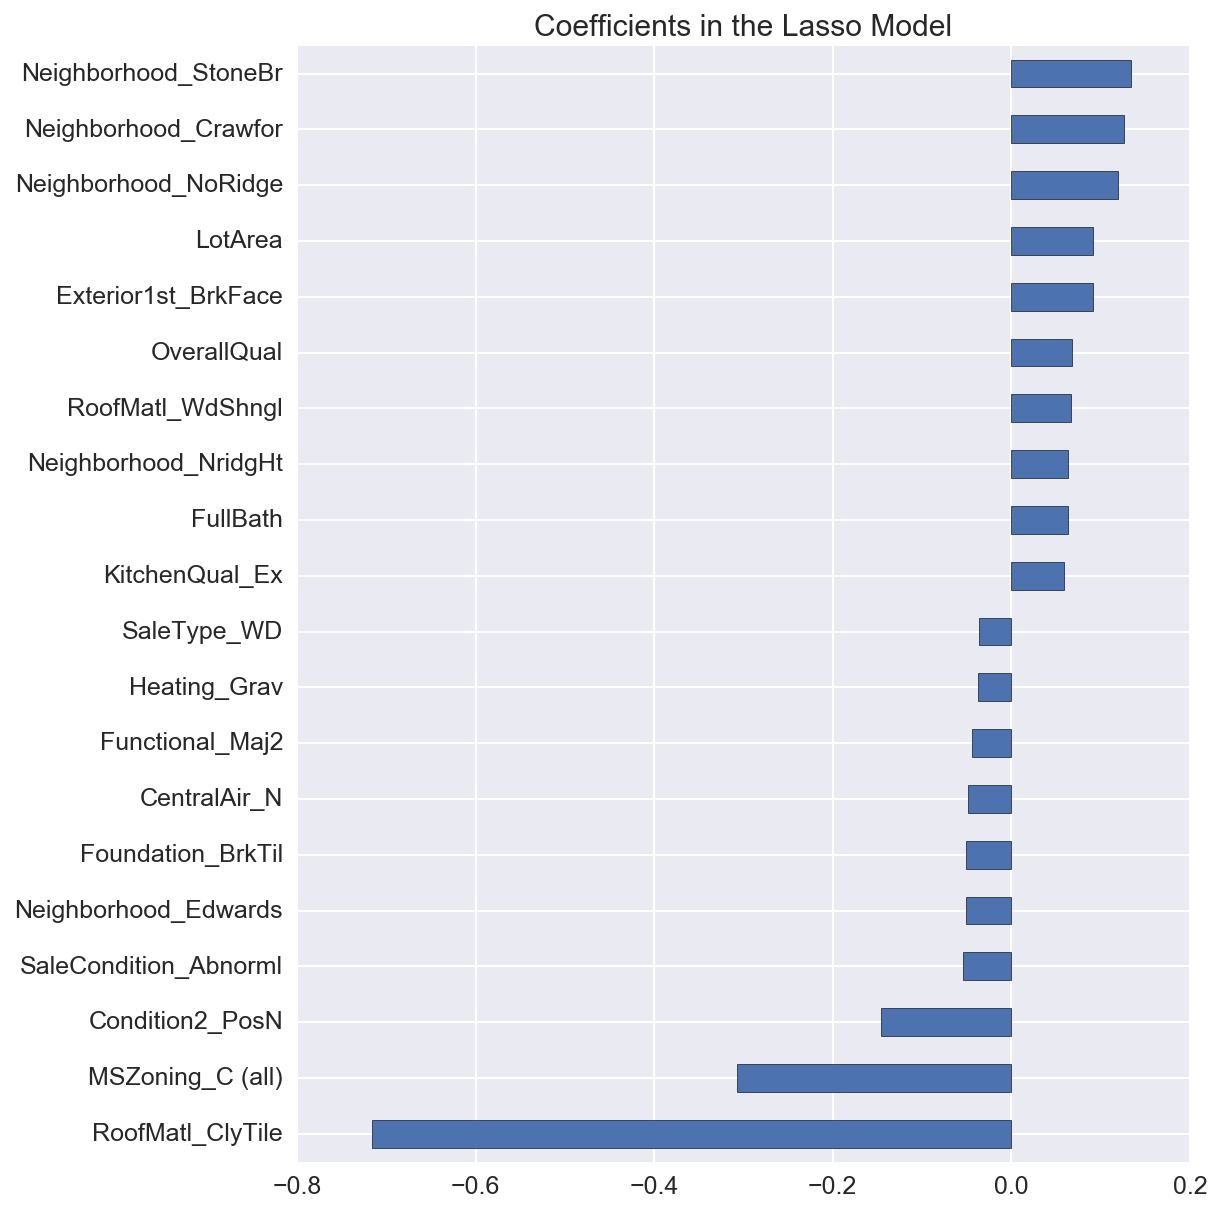

In [23]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [24]:
lasso_preds=np.expm1(model_lasso.predict(X_test))

## PCR(Principal component regression)

In [25]:
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error


C:\Users\Riheng Zhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We’ll start by performing Principal Components Analysis (PCA)

In [26]:
X_train.info()

pca = PCA()
X_reduced = pca.fit_transform(scale(X_train))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Columns: 284 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(273), int64(11)
memory usage: 3.2 MB


Let’s print out the ﬁrst few variables of the ﬁrst few principal components:

In [27]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.000028,0.127823,-0.106499,-0.074978,0.259529,0.180066
1,-0.052421,-0.078135,0.225489,-0.051666,-0.119607,-0.074171
2,-0.042393,-0.111414,0.284215,-0.074017,-0.042476,-0.077284
3,-0.188171,0.051813,0.077158,-0.044477,-0.023688,0.104602
4,0.057110,-0.038161,-0.004993,-0.118937,-0.075213,0.052234


Now we’ll perform 10-fold cross-validation to see how it inﬂuences the MSE:

In [28]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)
mse

[0.15963349293237505]

(-1, 100.0)

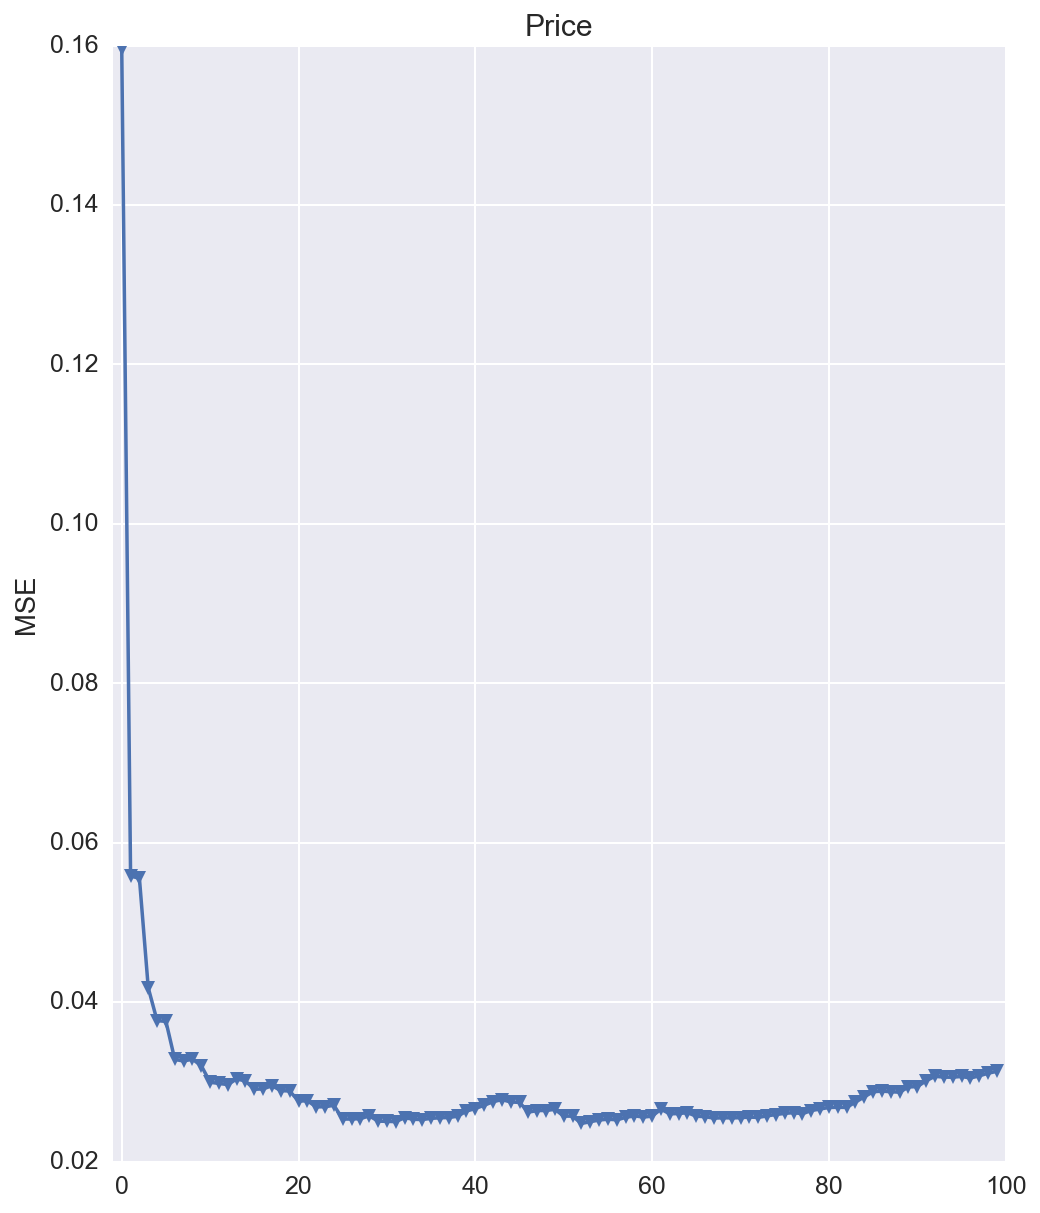

In [29]:
# Calculate MSE using CV for the 100 principle components, adding one component at the time.
for i in np.arange(1, 100):
    score = -1*cross_validation.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
# Plot results 
plt.plot(mse, '-v')
#plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1)

In [30]:
np.array(mse)
mse.index(min(mse))

52

We see that the smallest cross-validation error occurs when M = 52 components are used.
We’ll do a little math to get the amount of variance explained by adding each consecutive principal component:

In [31]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
arr[:52]

array([  5.93,   8.92,  11.08,  12.94,  14.69,  16.26,  17.77,  19.  ,
        20.21,  21.38,  22.52,  23.59,  24.63,  25.64,  26.64,  27.62,
        28.57,  29.5 ,  30.39,  31.26,  32.12,  32.98,  33.82,  34.65,
        35.47,  36.27,  37.05,  37.82,  38.58,  39.33,  40.06,  40.79,
        41.51,  42.22,  42.92,  43.62,  44.3 ,  44.98,  45.65,  46.31,
        46.96,  47.6 ,  48.24,  48.86,  49.47,  50.08,  50.68,  51.27,
        51.85,  52.42,  52.98,  53.54])

In [32]:
pca2 = PCA()

#Split into trainning and test sets
X_train_pcr, X_test_pcr, y_train_pcr, y_test_pcr = cross_validation.train_test_split(X_train,y,test_size=0.5,random_state=1)

# Scale the data
X_reduced_train_pcr = pca2.fit_transform(scale(X_train_pcr))
n = len(X_reduced_train_pcr)


In [33]:
# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state =1 )

mse = []

In [34]:
# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y_train_pcr.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

(-1, 160.0)

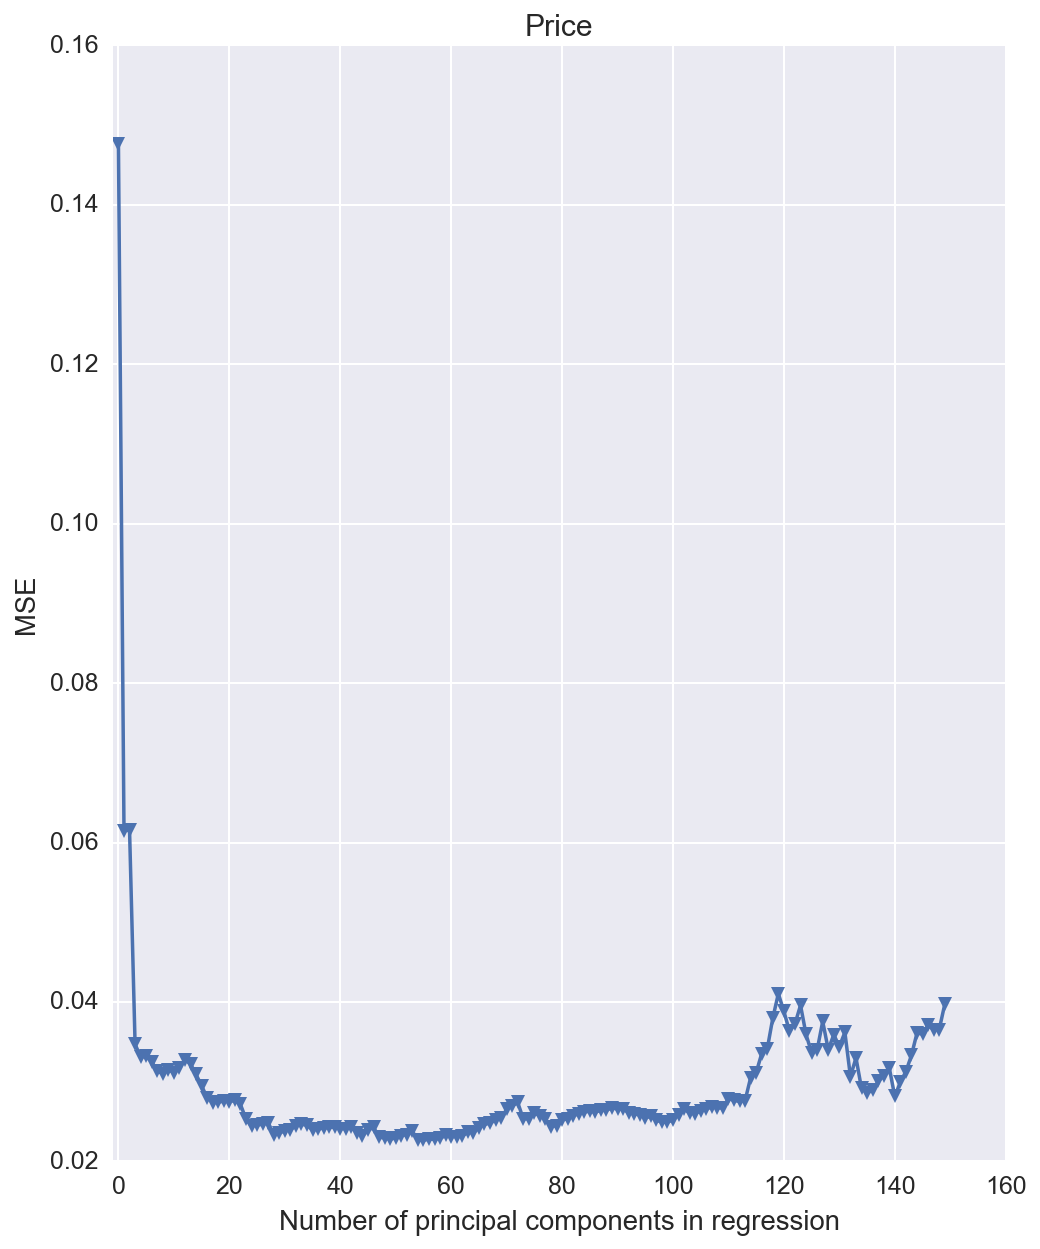

In [35]:
# Calculate MSE using CV for the 150 principal components, adding one component at the time
for i in np.arange(1, 150):
    score = -1*cross_validation.cross_val_score(regr, X_reduced_train_pcr[:,:i], y_train_pcr.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results 
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1)

We ﬁnd that the lowest cross-validation error occurs when M = 52 components are used. Now we’ll see how it performs on the test data and compute the test MSE as follows:

In [36]:
X_reduced_test_pcr = pca2.transform(scale(X_test_pcr))[:,:50]

# Train regression model on trainning data
regr = LinearRegression()
regr.fit(X_reduced_train_pcr[:,:50],y_train_pcr)

# Prediction with test data
pred = regr.predict(X_reduced_test_pcr)
mean_squared_error(y_test_pcr,pred)

0.026480254944869903

This test set MSE is competitive with the results obtained using ridge regression and the lasso. However, as a result of the way PCR is implemented, the ﬁnal model is more diﬃcult to interpret because it does not perform any kind of variable selection or even directly produce coeﬃcient estimates.

## Partial Least Squares

(-1, 25.0)

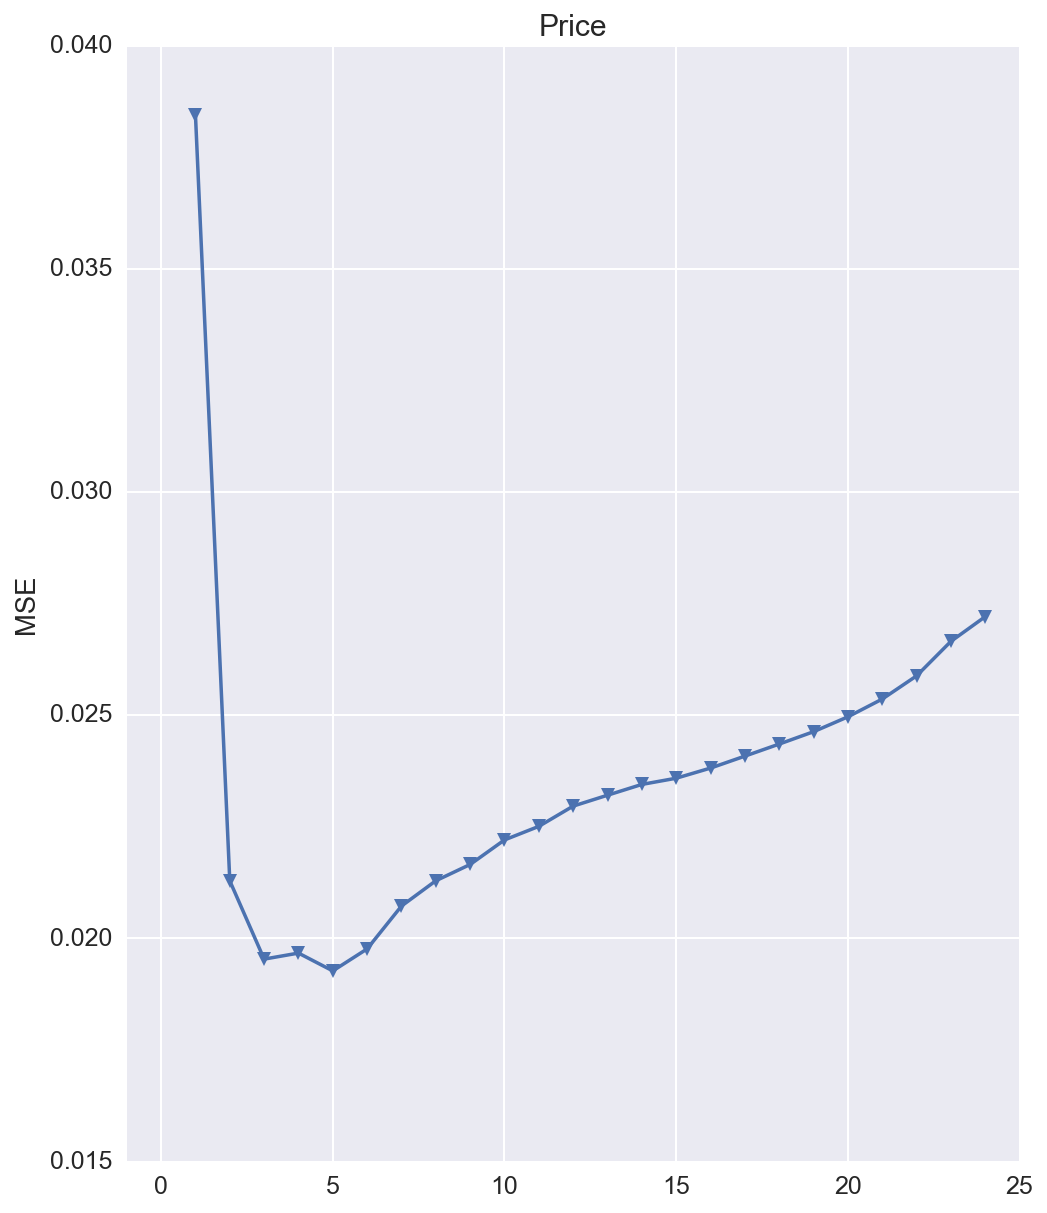

In [37]:
n = len(X_train_pcr)

#10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n,n_folds = 10, shuffle = True, random_state=1)

mse = []

for i in np.arange(1,25):
    pls = PLSRegression(n_components=i)
    score = cross_validation.cross_val_score(pls,scale(X_train_pcr),y_train_pcr, scoring="neg_mean_squared_error").mean()
    mse.append(-1*score)

# plot results
plt.plot(np.arange(1,25),np.array(mse),'-v')
#plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1)


The lowest cross-validation error occurs when only M = 5 partial least squares directions are used. We now evaluate the corresponding test set MSE:

In [38]:
pls = PLSRegression(n_components=5)
pls.fit(scale(X_train_pcr),y_train_pcr)

mean_squared_error(y_test_pcr,pls.predict(scale(X_test_pcr)))

0.029379106451819702

# Feature Selection(ReliefF)

In [109]:
feature=10
fs = ReliefF(n_neighbors=100, n_features_to_keep=feature)
train = fs.fit_transform(np.array(X_train), y)

In [110]:
feature_index=[]
for i in list(train[0,]):
    feature_index.append(list(X_train.ix[0]).index(i))
feature_index[0]
for f in feature_index:
    print (list(X_train.columns)[f])

LotArea
TotalBsmtSF
BsmtUnfSF
YearBuilt
LotFrontage
YearBuilt
BsmtFinSF1
FullBath
GarageArea
YrSold


# Data augmentation, increase gaussien noise

In [114]:
mu, sigma = 0, 0.1
s = np.random.normal(mu,sigma,1000)
len(s)
average = 0
for i in range(len(s)):
    average +=s[i]
average/len(s)

-0.0017896850953260375

### drop the variables whose coefficients are 0

In [39]:
index=model_lasso.coef_!=0
ind=list(index)

data=pd.DataFrame(all_data, columns=index)
data.shape
data.head()
columns=list(all_data.columns)
column=[]

for i in range(len(columns)):
    if ind[i]==False:
        column.append(columns[i])

all_data=all_data.drop(column,axis=1)

X_train=all_data[:train.shape[0]]
X_test=all_data[train.shape[0]:]
y=train.SalePrice
all_data.shape

(2919, 113)

## random forests

In [40]:
from sklearn.model_selection import train_test_split
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(X_train, y, test_size=0.25, random_state=40)
 
print("Number of features used for training: \t", len(rf_X_train), 
      "\nNumber of features used for testing: \t", len(rf_X_test))
 


Number of features used for training: 	 1095 
Number of features used for testing: 	 365


In [41]:
n_estimators=[2,5,8,10,20,30,40,50,60,70,80,90,100]
rf_train_error=[]
rf_test_error=[]
for n in n_estimators:
    mode_rf=RandomForestRegressor(n_estimators=n).fit(rf_X_train,rf_y_train)
    rf_train_error.append(mean_squared_error(mode_rf.predict(rf_X_train),rf_y_train))
    rf_test_error.append(mean_squared_error(mode_rf.predict(rf_X_test),rf_y_test))


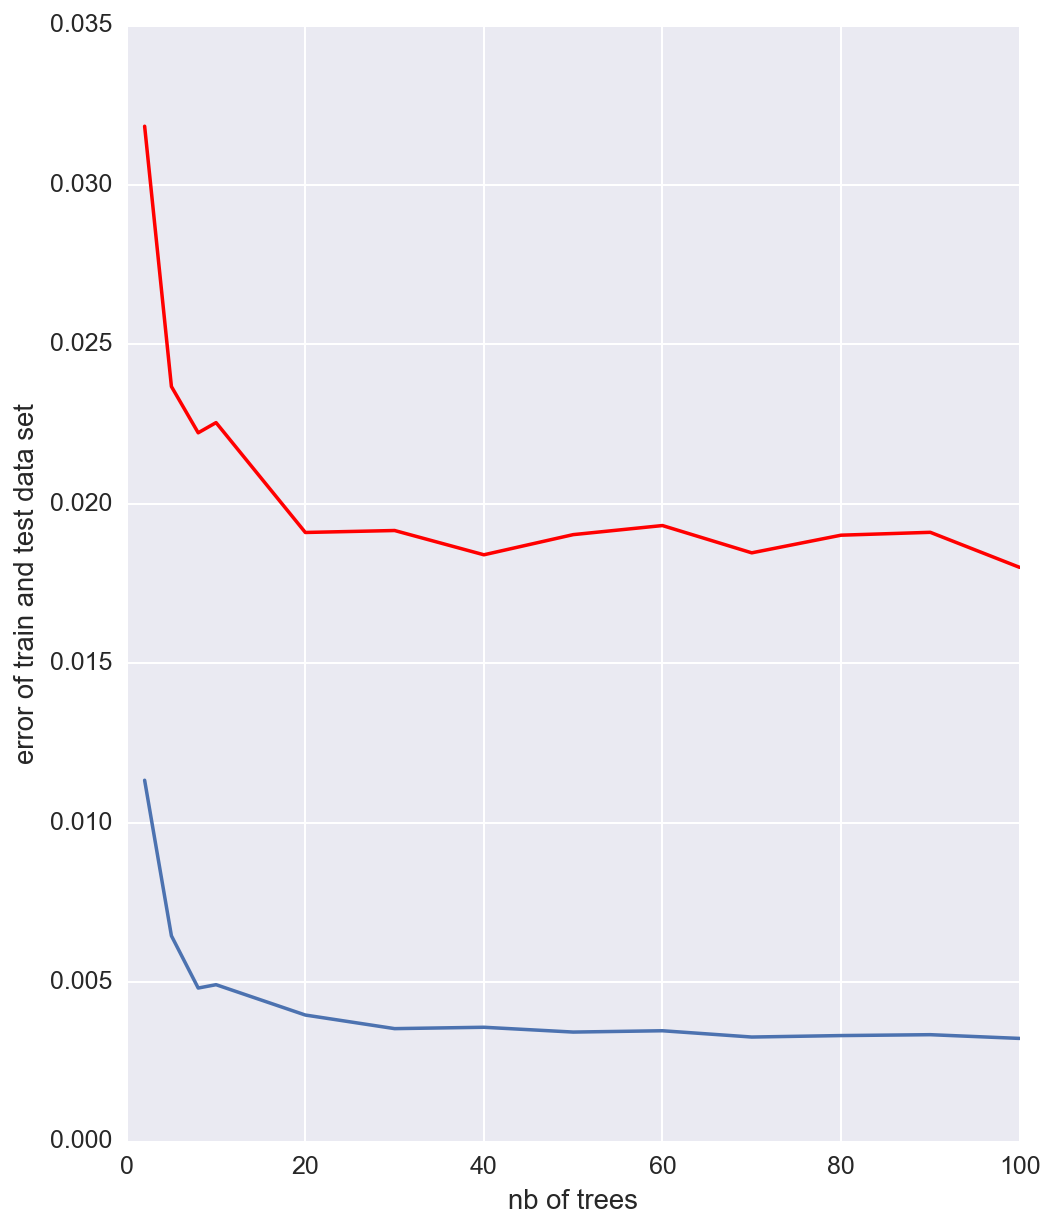

In [42]:
train_error = pd.Series(rf_train_error, index = n_estimators)
plt.plot( n_estimators,rf_train_error,  n_estimators,rf_test_error, 'r')
plt.xlabel('nb of trees')
plt.ylabel("error of train and test data set")

#### Here we want to see the influence of trees numbers on the score. Finally we chose 40 trees.

In [43]:
n_estimators=[2,5,8,10,20,30,40,50,60,70,80,90,100]
score=[cross_val_score(RandomForestRegressor(n_estimators=n),X_train, y).mean() for n in n_estimators]


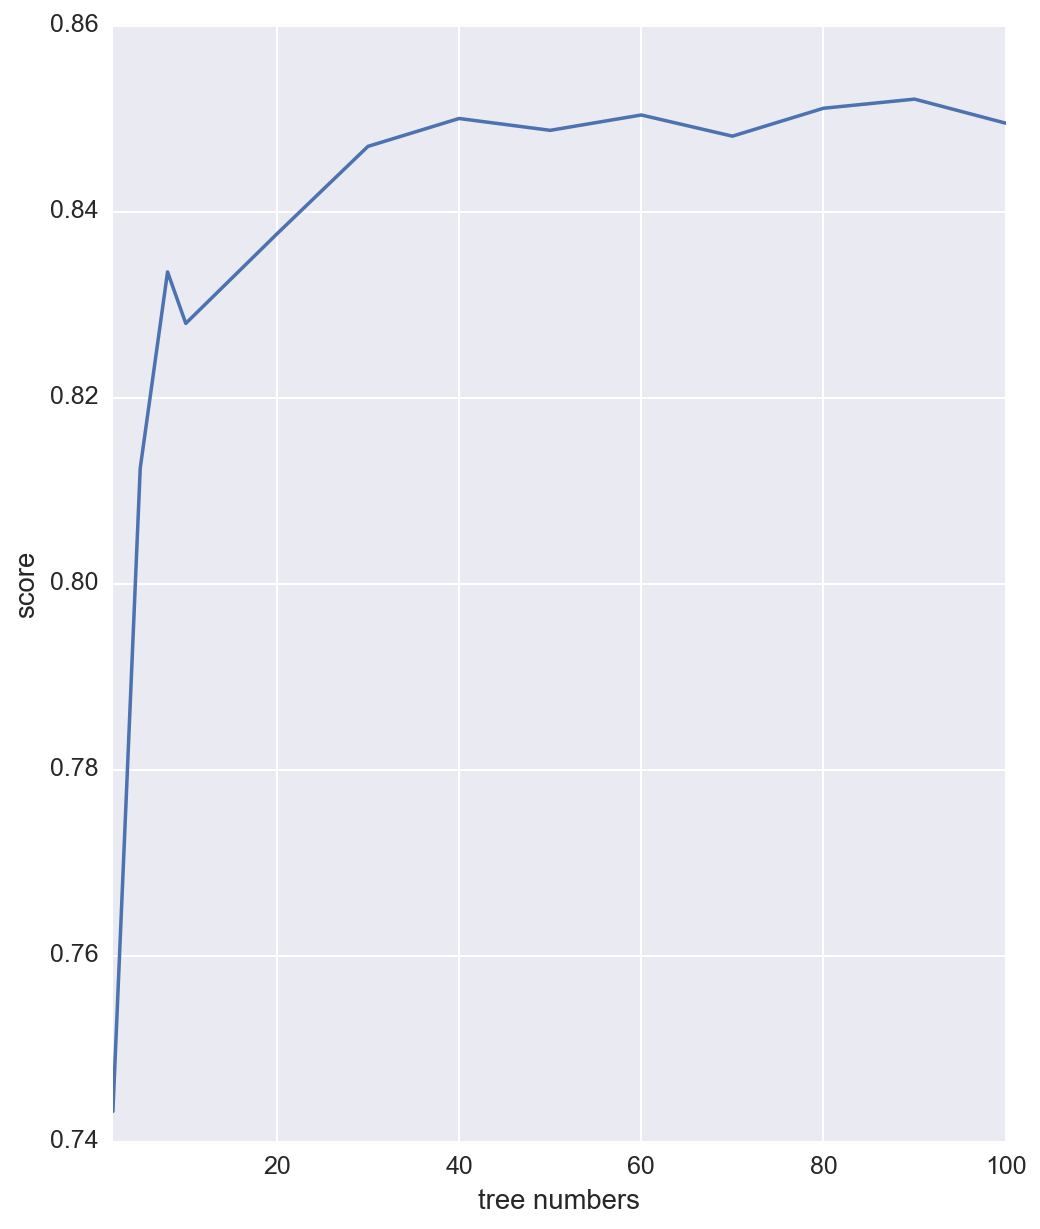

In [44]:
result = pd.Series(score, index = n_estimators)
result.plot()
plt.xlabel("tree numbers")
plt.ylabel("score")
 

In [45]:
model_rf_cv=RandomForestRegressor(n_estimators=40).fit(X_train,y)

In [46]:
np.mean(cross_val_score( model_rf_cv, X_train, y, cv=10))

0.86292452387285368

In [47]:
rf_preds=np.expm1(model_rf_cv.predict(X_test))


## Combine the lasso and random forest

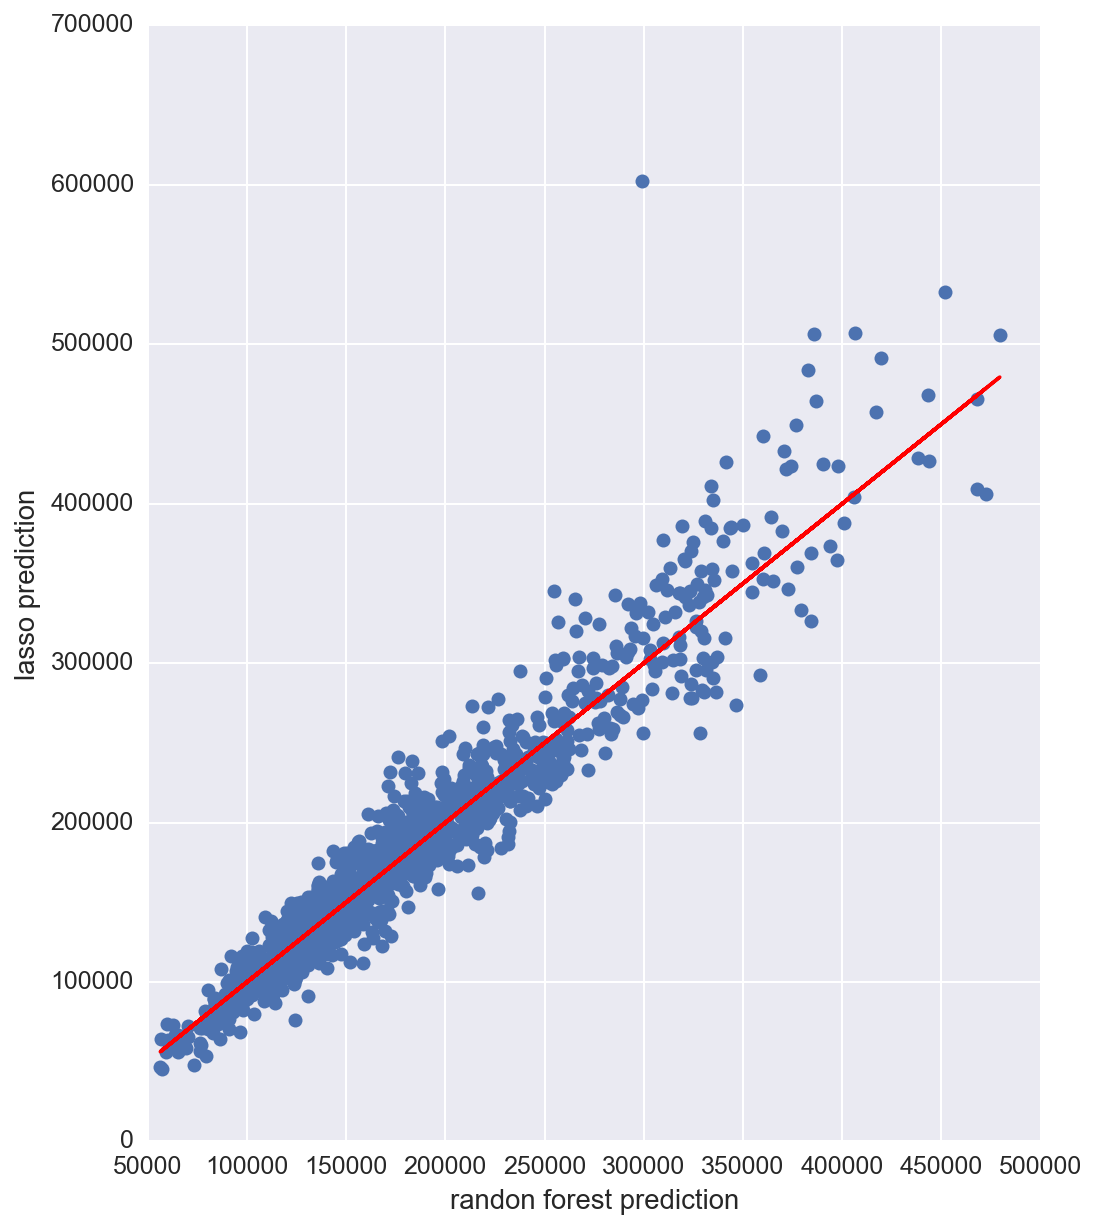

In [48]:
plt.plot(rf_preds, lasso_preds, 'o', rf_preds, rf_preds, 'r')
plt.xlabel("randon forest prediction")
plt.ylabel("lasso prediction")

In [49]:
preds = 0.7*lasso_preds + 0.3*rf_preds

In [50]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("submission.csv", index = False)

## Xgboost  ( Here is just a test)

In [51]:
#import xgboost as xgb

ImportError: No module named 'xgboost'

In [ ]:
#dtrain = xgb.DMatrix(X_train, label = y)
#dtest = xgb.DMatrix(X_test)

#params = {"max_depth":2, "eta":0.1}
#model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [ ]:
#model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()